# Exploring the Udacity labelled car dataset #
In this notebook we explore and process the Udacity dataset that has cars' bounding boxes labelled in over 9000 images. Some of the code is then used in the training and prediction process.


In [1]:
import numpy as np
import cv2
import csv
import matplotlib.pyplot as plt
import pickle
%matplotlib inline


## Utility functions ##

In [2]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=3, draw_dot=False, radius=7):
    ''' 
    This function draws out the bounding boxes for objects in the image as
    specified by the csv file
    '''
    # Make a copy of the image
    draw_img = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(draw_img, tuple(bbox[0]), tuple(bbox[1]), color, thick)
        if draw_dot:
            centre = (np.array(bbox[0]) + np.array(bbox[1])) // 2
            cv2.circle(draw_img, tuple(centre), radius=radius, color=(0, 255, 0), thickness=-1)
    # Return the image copy with boxes drawn
    return draw_img

def draw_grid(img, grid=11, thick=3):
    '''
    Visualize gridcells over the given image
    '''
    x, y = img.shape[1], img.shape[0]
    x_inc, y_inc = x//grid, y//grid
    
    for a in range(grid):
        cv2.line(img, (a*x_inc, 0), (a*x_inc, y), color=(255,0,0), thickness=thick)
    for b in range(grid):
        cv2.line(img, (0, b*y_inc), (x, b*y_inc), color=(255,0,0), thickness=thick)
    return img

def frame_dict(labels_rows, scalex=1, scaley=1):
    frames = {}
    for row in labels_rows[1:] :
        if str(row[4]) not in frames:
            frames[str(row[4])] = []
        frames[str(row[4])].append( ( 
            ((int(int(row[0])//scalex), int(int(row[1])//scaley)) , (int(int(row[2])//scalex), int(int(row[3])//scaley)))  ,  
            (int(row[5]=='Car'), int(row[5]=='Truck'), int(row[5]=='Pedestrian')) 
        ) )
    return frames

def label_to_tensor(frame, imgsize=(224, 224), gridsize=(11,11), classes=3, bboxes=2):
    '''
    label_to_tensor() function takes in a frame label info from the dataset and 
    returns an array of shape SS(C+5B): [ClassProb--Confidence--x/y/w/h]
    Confidence is set to zero as it needs to be calculated at training time for each BBox predicted by the classifier
    '''
    grid = np.zeros(gridsize)
    
    y_span = imgsize[0]/gridsize[0]
    x_span = imgsize[1]/gridsize[1]
    
    class_prob = np.zeros((gridsize[0], gridsize[1], classes))
    confidence = np.zeros((gridsize[0], gridsize[1], bboxes))
    dims = np.zeros((gridsize[0], gridsize[1], bboxes, 4))
    
    for box in frame:
        ((x1,y1), (x2,y2)), (c1,c2,c3) = box
        x_grid = int(((x1+x2)/2)//x_span)
        y_grid = int(((y1+y2)/2)//y_span)
        
        class_prob[y_grid, x_grid] = (c1,c2,c3)
        
        x_center = ((x1+x2)/2)
        y_center = ((y1+y2)/2)
        
        x_center_norm = (x_center-x_grid*x_span)/(x_span)
        y_center_norm = (y_center-y_grid*y_span)/(y_span)
        
        w = x2-x1
        h = y2-y1
        
        w_norm = w/imgsize[1]
        h_norm = h/imgsize[0]
        
        dims[y_grid, x_grid, :, :] = (x_center_norm, y_center_norm, w_norm, h_norm)
        
        grid[y_grid, x_grid] += 1
        
    tensor = np.concatenate((class_prob.ravel(), confidence.ravel(), dims.ravel()))
    return grid, tensor


In [3]:

def coord_translate(bboxes, tr_x, tr_y):
    '''
    Takes a singl frame's bounding box list with confidence scores and
    applies translation (addition) to the coordinates specified by 'tr'

    parameters:
    bboxes: list with element of the form ((x1,y1), (x2,y2)), (c1,c2,c3)
    tr_x, tr_y: translation factor to add the coordinates to, for x and y respectively

    returns: new list with translated coordinates and same conf scores; same shape as bboxes
    '''
    new_list = []
    for box in bboxes:
        coords = np.array(box[0])
        coords[:,0] = coords[:,0] + tr_x
        coords[:,1] = coords[:,1] + tr_y
        coords = coords.tolist()
        new_list.append((coords, box[1]))
    return new_list
def coord_scale(bboxes, sc):
    '''
    Takes a singl frame's bounding box list with confidence scores and
    applies scaling to the coordinates specified by sc

    parameters:
    bboxes: list with element of the form ((x1,y1), (x2,y2)), (c1,c2,c3)
    sc: scaling factor to multiply the coordinates with

    returns: new list with scaled coordinates and same conf scores; same shape as bboxes
    '''
    new_list = []
    for box in bboxes:
        coords = np.array(box[0])
        coords = coords * sc
        coords = coords.astype(np.int64)
        out_of_bound_indices = coords[0,:]>224
        if out_of_bound_indices.any():
            continue
        coords = coords.tolist()
        new_list.append((coords, box[1]))
    return new_list
def augument_data(label, frame, imgsize=(224, 224), folder='udacity-object-detection-crowdai/'):
    '''
    Takes the image file name and the frame (rows corresponding to a single image in the labels.csv)
    and randomly scales, translates, adjusts SV values in HSV space for the image,
    and adjusts the coordinates in the 'frame' accordingly, to match bounding boxes in the new image
    '''
    img = cv2.imread(folder+label)
    img = cv2.resize(img, imgsize)
    rows, cols = img.shape[:2]

    #translate_factor
    tr = np.random.random() * 0.2
    tr_y = np.random.randint(rows*-tr,rows*tr)
    tr_x = np.random.randint(cols*-tr, cols*tr)
    #scale_factor
    sc = np.random.random() * 0.4 + 0.8

    # flip coin to adjust image saturation
    r = np.random.rand()
    if r < 0.5:
        #randomly adjust the S and V values in HSV representation
        img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(np.float32)
        fs = np.random.random() + 0.7
        fv = np.random.random() + 0.2
        img[:,:,1] *= fs
        img[:,:,2] *= fv
        img = img.astype(np.uint8)
        img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
        print('adjusted SV: {}, {}'.format(fs, fv))

    # new random factor for scaling and translating
    r = np.random.rand()

    if r < 0.3:
        #translate image
        M = np.float32([[1,0,tr_x], [0,1,tr_y]])
        img = cv2.warpAffine(img, M, (cols,rows))
        frame = coord_translate(frame, tr_x, tr_y)
        print('translating by: {}, {}'.format(tr_x, tr_y))
    elif r < 0.6:
        #scale image keeping the same size
        placeholder = np.zeros_like(img)
        meta = cv2.resize(img, (0,0), fx=sc, fy=sc)
        if sc < 1:
            placeholder[:meta.shape[0], :meta.shape[1]] = meta
        else:
            placeholder = meta[:placeholder.shape[0], :placeholder.shape[1]]
        img = placeholder
        frame = coord_scale(frame, sc)
        print('scaled by: {}'.format(sc))

    return img, frame

In [4]:
labels_rows = []
with open('udacity-object-detection-crowdai/labels.csv', 'r') as f:
    csvrows = csv.reader(f)
    for row in csvrows:
        labels_rows.append(row)

In [5]:
print(len(labels_rows))
print(labels_rows[0])

72065
['xmin', 'xmax', 'ymin', 'ymax', 'Frame', 'Label', 'Preview URL']


In [6]:
np.unique(np.array(labels_rows)[:,5], return_counts=True)

(array(['Car', 'Label', 'Pedestrian', 'Truck'], dtype='<U52'),
 array([62570,     1,  5675,  3819], dtype=int64))

We can see above that the dataset is uneven across different classes. It can additionally be noted that a certain view (rear) of cars dominates the rest (side and front).

In [7]:
frames = {}
for row in labels_rows[1:] :
    if str(row[4]) not in frames:
        frames[str(row[4])] = []
    frames[str(row[4])].append( ( 
        ((int(row[0]), int(row[1])) , (int(row[2]), int(row[3])))  ,  
        (int(row[5]=='Car'), int(row[5]=='Truck'), int(row[5]=='Pedestrian')) 
    ) )

In [8]:
len(frames)

9218

Now we have a dictionary with the file names as labels and their corrresponding bounding boxes and class probabilities as values:

In [9]:
frames['1479498371963069978.jpg']

[(((785, 533), (905, 644)), (1, 0, 0)),
 (((89, 551), (291, 680)), (1, 0, 0)),
 (((268, 546), (383, 650)), (1, 0, 0)),
 (((455, 522), (548, 615)), (0, 1, 0)),
 (((548, 522), (625, 605)), (0, 1, 0)),
 (((1726, 484), (1919, 646)), (1, 0, 0)),
 (((758, 557), (807, 617)), (1, 0, 0)),
 (((633, 561), (680, 597)), (1, 0, 0)),
 (((682, 557), (718, 593)), (1, 0, 0))]

In [10]:
x = np.array(frames['1479498371963069978.jpg'])
np.array(x[:,0])

array([((785, 533), (905, 644)), ((89, 551), (291, 680)),
       ((268, 546), (383, 650)), ((455, 522), (548, 615)),
       ((548, 522), (625, 605)), ((1726, 484), (1919, 646)),
       ((758, 557), (807, 617)), ((633, 561), (680, 597)),
       ((682, 557), (718, 593))], dtype=object)

Let's create a dictionary with scaled image data since we will be using (224,224) images in our network:


In [11]:
frames_scaled = frame_dict(labels_rows[1:], scalex=1920/224, scaley=1200/224)

## Visualize ##

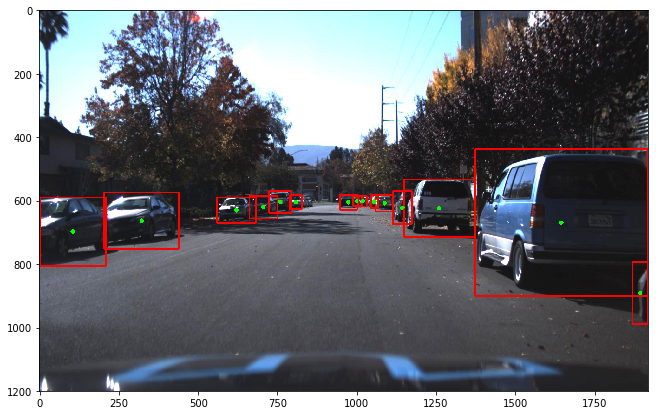

In [34]:
im_name = '1479498379965419997.jpg'
img = cv2.imread('udacity-object-detection-crowdai/' + im_name)
frame_np = np.array(frames[im_name])
draw_img = draw_boxes(img, frame_np[:,0], draw_dot=True)
cv2.imwrite('bboxes.jpg', draw_img)
plt.figure(figsize=(12,7))
plt.imshow(draw_img[:,:,::-1])

Overlay grid:

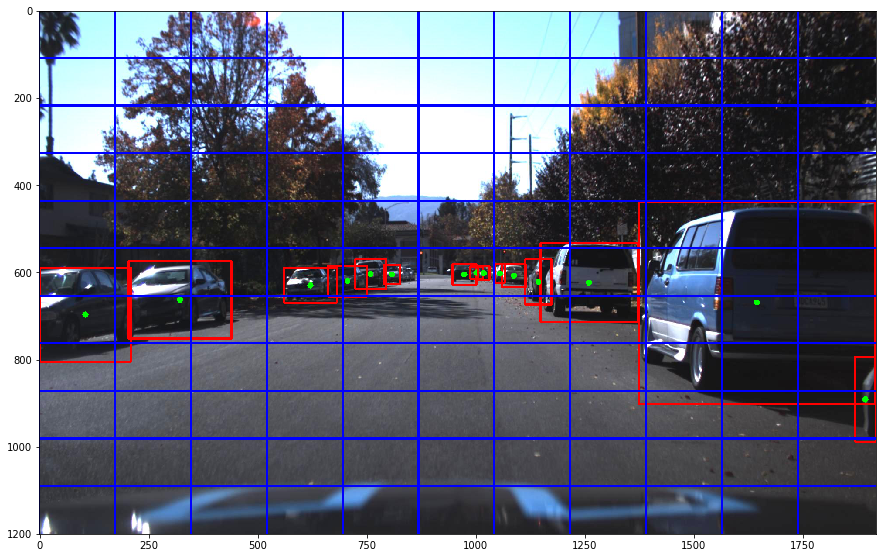

In [35]:
draw_img = draw_grid(draw_img)
cv2.imwrite('bboxes_grid.jpg', draw_img)
plt.figure(figsize=(15,30))
plt.imshow(draw_img[:,:,::-1])

### Visualize augumented and scaled images: ###

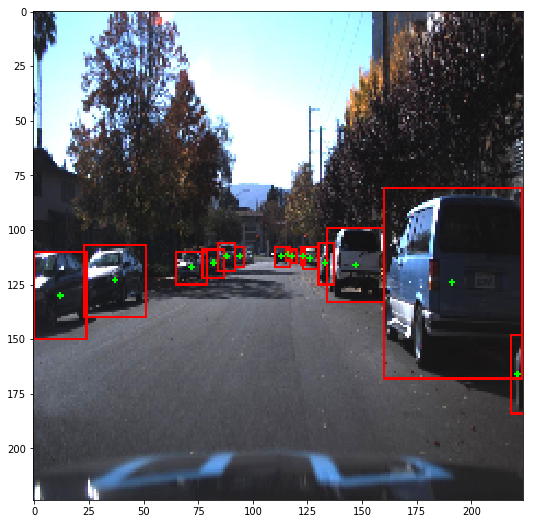

In [67]:
im_name = '1479498379965419997.jpg'
img2 = cv2.imread('udacity-object-detection-crowdai/' + im_name)
img2 = cv2.resize(img2, (224,224))
img2, frame_np = augument_data(im_name, frames_scaled[im_name])
draw_img2 = draw_boxes(img2, np.array(frame_np)[:,0], thick=1, draw_dot=True, radius=1)
plt.figure(figsize=(15,9))
plt.imshow(draw_img2[:,:,::-1])

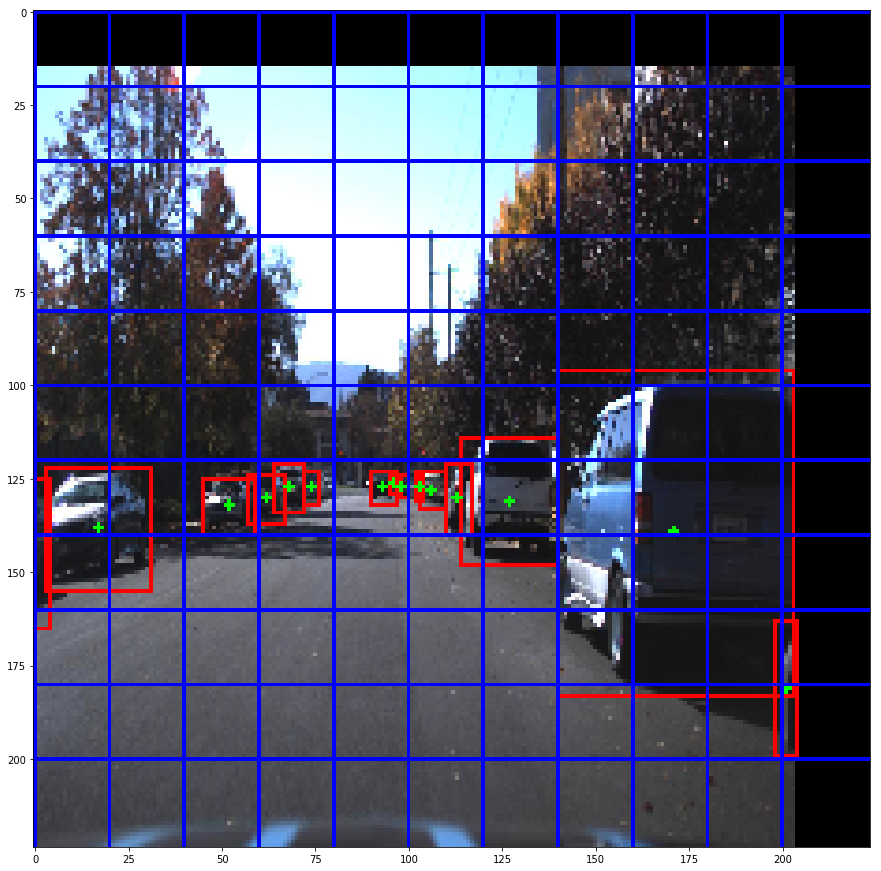

In [27]:
draw_img2 = draw_grid(draw_img2, thick=1)
plt.figure(figsize=(15,30))
plt.imshow(draw_img2[:,:,::-1])

## Test conversion to 1D array ##
The grid size selected (11,11) does not allow for recording all labeled objects in an images, especially the ones that are at a far distance and clustered together (as seen in the image above). Only one detection is considered per gridcell and hence some labeled objects are suppresed. The 'grid' variable below shows how many overlaps were found. 

In [28]:
grid, tensor = label_to_tensor(frames_scaled[im_name], gridsize=(11,11) )

In [29]:
grid

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 3., 3., 3., 1., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [30]:
tensor.shape

(1573,)

In [31]:
np.average(tensor)

0.019139950958132777

In [ ]:
label_tensors = {}
for frame in frames_scaled:
    _, tensor = label_to_tensor(frames_scaled[frame])
    label_tensors[frame] = tensor


In [ ]:
len(label_tensors)

In [ ]:
with open('label_tensors.p', 'wb') as f:
    pickle.dump(label_tensors, f)

In [ ]:
with open('label_frames.p', 'wb') as f:
    pickle.dump(frames_scaled, f)

In [ ]:
len(frames_scaled)